In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
df = pd.read_excel('Godzilla.xlsx')

# Define features and target
features = ['Budget', 'Release Date', 'Era', 'Runtime', 'Kaiju Height']
target = 'Revenue'

# Handle missing values
numerical_features = ['Budget', 'Runtime', 'Kaiju Height']
categorical_features = ['Era', 'Release Date']

In [8]:
df.head()

,Position,English Title,Japanese Title,IMDb Rating,Rotten Tomatoes Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Godzilla's Sizes (In Feet),Godzilla's Sizes (In Meters),Era,Number of Monsters,Tickets Sold,Movie Budget (Yen),Final Revenue (Yen),URL
0,1,Godzilla (1954),Gojira,7.5,0.93,96,1954,"Horror, Sci-Fi",33861,1954-11-03,Ishirô Honda,164,50,Showa,1,9610000,"¥101,000,000","¥183,000,000",https://www.imdb.com/title/tt0047034/
1,2,Godzilla Raids Again,Gojira no gyakushû,5.8,0.60,82,1955,"Action, Horror, Sci-Fi",6922,1955-04-24,"Ishirô Honda, Motoyoshi Oda",164,50,Showa,2,8340000,"¥100,000,000","¥170,000,000",https://www.imdb.com/title/tt0048127/
2,3,King Kong vs. Godzilla,King Kong vs. Godzilla,5.7,0.50,97,1962,"Action, Adventure, Fantasy, Sci-Fi",10398,1963-06-03,"Tom Montgomery, Ishirô Honda",164,50,Showa,1,11200000,"¥150,000,000","¥430,000,000",https://www.imdb.com/title/tt0056142/
3,4,Mothra vs. Godzilla,Mosura tai Gojira,6.5,0.92,89,1964,"Adventure, Fantasy, Sci-Fi",8934,1964-04-29,Ishirô Honda,164,50,Showa,2,7220000,"¥123,000,000","¥625,000,000",https://www.imdb.com/title/tt0058379/
4,5,Ghidorah: The Three-Headed Monster,San daikaijû: Chikyû saidai no kessen,6.5,0.75,93,1964,"Action, Adventure, Fantasy, Sci-Fi, Thriller",6703,1964-12-20,Ishirô Honda,164,50,Showa,4,5410000,-,"¥390,000,000",https://www.imdb.com/title/tt0058544/


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Position                      36 non-null     int64         
 1   English Title                 36 non-null     object        
 2   Japanese Title                36 non-null     object        
 3   IMDb Rating                   36 non-null     float64       
 4   Rotten Tomatoes Rating        35 non-null     float64       
 5   Runtime (mins)                36 non-null     int64         
 6   Year                          36 non-null     int64         
 7   Genres                        36 non-null     object        
 8   Num Votes                     36 non-null     int64         
 9   Release Date                  36 non-null     datetime64[ns]
 10  Directors                     36 non-null     object        
 11  Godzilla's Sizes (In Feet)    36 n

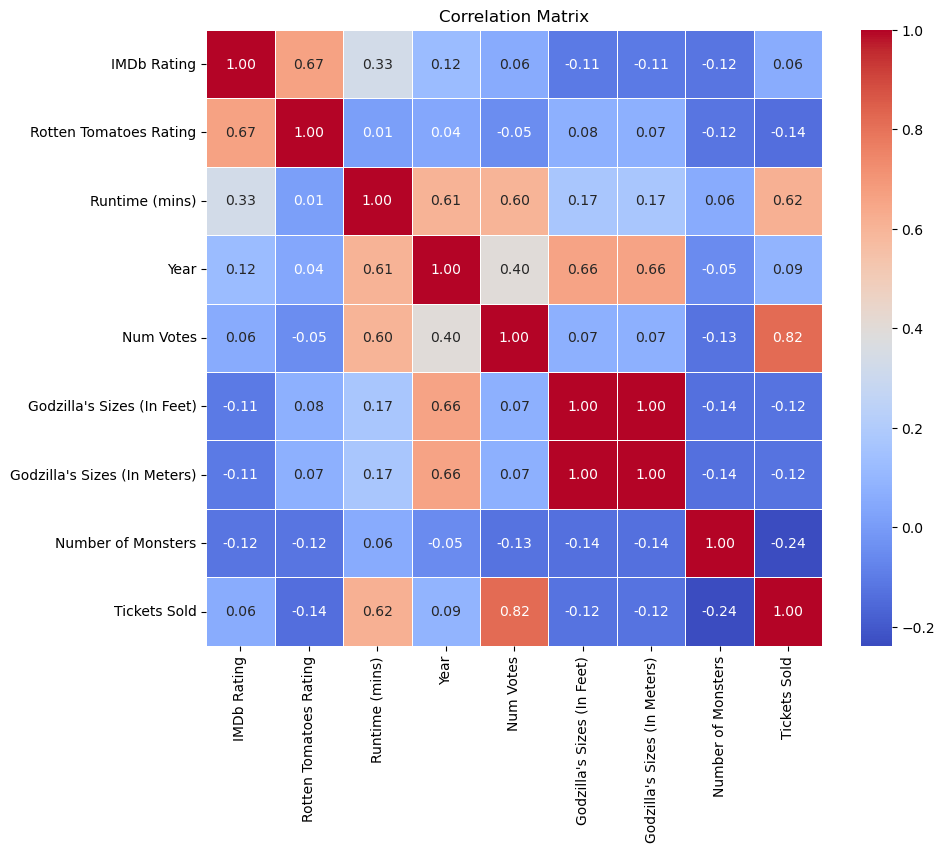

In [7]:
# Calculate the correlation matrix using the relevant numeric columns
numeric_columns = [
    'IMDb Rating', 'Rotten Tomatoes Rating', 'Runtime (mins)', 
    'Year', 'Num Votes', "Godzilla's Sizes (In Feet)", "Godzilla's Sizes (In Meters)", 
    'Number of Monsters', 'Tickets Sold'
]

['Budget', 'Year', 'Era', 'Runtime (mins)', "Godzilla's Sizes (In Feet)"]


corr_matrix = df[numeric_columns].corr()

# Create a heatmap with Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Apply preprocessing
X = df[features]
y = df[target]

X_preprocessed = preprocessor.fit_transform(X)

# Convert the preprocessed features back to a DataFrame for easier inspection
preprocessed_feature_names = numerical_features + \
                            list(preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))

X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=preprocessed_feature_names)

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

In [ ]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': preprocessed_feature_names,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)